# First contact with the dataset
This Notebook has as objective to replicate the baseline results from Minixhofer et al. (2021)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter



**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [16]:
writer = SummaryWriter('../logs/LSTM_Minixhofer')

## Importing the data in a unique dictionary

In [17]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [18]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }


In [19]:
# dataDic["train"].columns

In [20]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [21]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [22]:
# dfs["train"]

## Interpolation pour les données manquantes

In [23]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [24]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [25]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [26]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [ ]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [28]:
# # export all
# import pickle
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)

In [2]:
# import all
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)


In [3]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 10
clip = 5

In [4]:
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)
test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)


In [5]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1):
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim + static_dim, hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static=None):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        if static is not None:
            static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [7]:
static_dim = X_tabular_train.shape[-1]

In [34]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0
if use_static:
    static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)
model.to(device)
loss_function = nn.MSELoss()
if one_cycle:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        if use_static:
            output, h = model(inputs, h, static)
        else:
            output, h = model(inputs, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if one_cycle:
            scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    if use_static:
                        out, val_h = model(inp, val_h, stat)
                    else:
                        out, val_h = model(inp, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./state_dict.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/10:  50%|█████     | 380/759 [02:11<09:05,  1.44s/it]

{'loss': 0.4682058095932007, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 1, 'validation_loss': np.float64(0.5068514868617058), 'macro_f1': np.float64(0.37552201215848635), 'micro_f1': np.float64(0.49776149776149775), 'mae': np.float64(0.5191986092335601)}
{'loss': 0.4682058095932007, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 2, 'validation_loss': np.float64(0.5068514868617058), 'macro_f1': np.float64(0.30334144252566636), 'micro_f1': np.float64(0.46682946682946685), 'mae': np.float64(0.5631105416154832)}
{'loss': 0.4682058095932007, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 3, 'validation_loss': np.float64(0.5068514868617058), 'macro_f1': np.float64(0.33617903063718385), 'micro_f1': np.float64(0.5087505087505088), 'mae': np.float64(0.5737831430013581)}
{'loss': 0.4682058095932007, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 7.317018257621514e-06, 'week': 4, 'validation_loss'

epoch 1/10: 100%|██████████| 759/759 [04:24<00:00,  2.87it/s]


{'loss': 0.21008244156837463, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 1, 'validation_loss': np.float64(0.18993906639516353), 'macro_f1': np.float64(0.7376192653660891), 'micro_f1': np.float64(0.8897028897028897), 'mae': np.float64(0.2001351743996216)}
{'loss': 0.21008244156837463, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 2, 'validation_loss': np.float64(0.18993906639516353), 'macro_f1': np.float64(0.6980739055468236), 'micro_f1': np.float64(0.8542938542938543), 'mae': np.float64(0.2409895012017329)}
{'loss': 0.21008244156837463, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 3, 'validation_loss': np.float64(0.18993906639516353), 'macro_f1': np.float64(0.6315479463298612), 'micro_f1': np.float64(0.8241758241758241), 'mae': np.float64(0.2725415545234229)}
{'loss': 0.21008244156837463, 'epoch': 1.0, 'step': 759, 'lr': 1.9613390103485664e-05, 'week': 4, 'validation_loss': np.float64(0.18993906639516353), 'macro_f1': np.floa

epoch 2/10:  50%|█████     | 380/759 [02:13<09:20,  1.48s/it]

{'loss': 0.2536115348339081, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 1, 'validation_loss': np.float64(0.1866351455450058), 'macro_f1': np.float64(0.7612902154976311), 'micro_f1': np.float64(0.8994708994708994), 'mae': np.float64(0.18138067067095032)}
{'loss': 0.2536115348339081, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 2, 'validation_loss': np.float64(0.1866351455450058), 'macro_f1': np.float64(0.7033627287859526), 'micro_f1': np.float64(0.8620268620268621), 'mae': np.float64(0.22238491633863505)}
{'loss': 0.2536115348339081, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 3, 'validation_loss': np.float64(0.1866351455450058), 'macro_f1': np.float64(0.6567885218406236), 'micro_f1': np.float64(0.8290598290598291), 'mae': np.float64(0.26155742234713814)}
{'loss': 0.2536115348339081, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 3.644637850599361e-05, 'week': 4, 'validation_los

epoch 2/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.36559194326400757, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 1, 'validation_loss': np.float64(0.1630071025341749), 'macro_f1': np.float64(0.7840946599869474), 'micro_f1': np.float64(0.905982905982906), 'mae': np.float64(0.15479216876223556)}
{'loss': 0.36559194326400757, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 2, 'validation_loss': np.float64(0.1630071025341749), 'macro_f1': np.float64(0.7237337268126058), 'micro_f1': np.float64(0.8722018722018722), 'mae': np.float64(0.1937137768286112)}
{'loss': 0.36559194326400757, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 3, 'validation_loss': np.float64(0.1630071025341749), 'macro_f1': np.float64(0.6491488544205116), 'micro_f1': np.float64(0.8355718355718356), 'mae': np.float64(0.23349119904691196)}
{'loss': 0.36559194326400757, 'epoch': 2.0, 'step': 1518, 'lr': 5.322676953465756e-05, 'week': 4, 'validation_loss': np.float64(0.1630071025341749), 'macro_f1': np.float64

epoch 3/10:  50%|█████     | 380/759 [02:13<09:08,  1.45s/it]

{'loss': 0.19800220429897308, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 1, 'validation_loss': np.float64(0.1600946919992566), 'macro_f1': np.float64(0.7867048702987725), 'micro_f1': np.float64(0.9104599104599105), 'mae': np.float64(0.13936151175112396)}
{'loss': 0.19800220429897308, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 2, 'validation_loss': np.float64(0.1600946919992566), 'macro_f1': np.float64(0.7161205515028), 'micro_f1': np.float64(0.8685388685388685), 'mae': np.float64(0.18796850105767865)}
{'loss': 0.19800220429897308, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 3, 'validation_loss': np.float64(0.1600946919992566), 'macro_f1': np.float64(0.6604536597262014), 'micro_f1': np.float64(0.8351648351648352), 'mae': np.float64(0.23486902900679615)}
{'loss': 0.19800220429897308, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.552932328331287e-05, 'week': 4, 'validation_lo

epoch 3/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.3243669271469116, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 1, 'validation_loss': np.float64(0.16004754565656185), 'macro_f1': np.float64(0.8020395253715535), 'micro_f1': np.float64(0.9092389092389093), 'mae': np.float64(0.13935389314324856)}
{'loss': 0.3243669271469116, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 2, 'validation_loss': np.float64(0.16004754565656185), 'macro_f1': np.float64(0.735619077725351), 'micro_f1': np.float64(0.8689458689458689), 'mae': np.float64(0.18558225736157605)}
{'loss': 0.3243669271469116, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 3, 'validation_loss': np.float64(0.16004754565656185), 'macro_f1': np.float64(0.68183998021465), 'micro_f1': np.float64(0.8359788359788359), 'mae': np.float64(0.22749811777268958)}
{'loss': 0.3243669271469116, 'epoch': 3.0, 'step': 2277, 'lr': 6.999999388133871e-05, 'week': 4, 'validation_loss': np.float64(0.16004754565656185), 'macro_f1': np.float64(

epoch 4/10:  50%|█████     | 380/759 [02:13<09:08,  1.45s/it]

{'loss': 0.2202976942062378, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 1, 'validation_loss': np.float64(0.1450965454801917), 'macro_f1': np.float64(0.786756277101199), 'micro_f1': np.float64(0.9055759055759056), 'mae': np.float64(0.13700219896763358)}
{'loss': 0.2202976942062378, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 2, 'validation_loss': np.float64(0.1450965454801917), 'macro_f1': np.float64(0.7221786053265945), 'micro_f1': np.float64(0.8685388685388685), 'mae': np.float64(0.1786460118228469)}
{'loss': 0.2202976942062378, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 3, 'validation_loss': np.float64(0.1450965454801917), 'macro_f1': np.float64(0.6687518313598487), 'micro_f1': np.float64(0.8400488400488401), 'mae': np.float64(0.21476318163694674)}
{'loss': 0.2202976942062378, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.911555923555037e-05, 'week': 4, 'validation_loss'

epoch 4/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.239888995885849, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 1, 'validation_loss': np.float64(0.15423369258642197), 'macro_f1': np.float64(0.8308491943020769), 'micro_f1': np.float64(0.9173789173789174), 'mae': np.float64(0.12793801328018944)}
{'loss': 0.239888995885849, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 2, 'validation_loss': np.float64(0.15423369258642197), 'macro_f1': np.float64(0.7308058270070722), 'micro_f1': np.float64(0.8791208791208791), 'mae': np.float64(0.17810608976199757)}
{'loss': 0.239888995885849, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 3, 'validation_loss': np.float64(0.15423369258642197), 'macro_f1': np.float64(0.6571113128086977), 'micro_f1': np.float64(0.8433048433048433), 'mae': np.float64(0.21987606230893658)}
{'loss': 0.239888995885849, 'epoch': 4.0, 'step': 3036, 'lr': 6.652493927871029e-05, 'week': 4, 'validation_loss': np.float64(0.15423369258642197), 'macro_f1': np.float64(0

epoch 5/10:  50%|█████     | 380/759 [02:13<09:07,  1.44s/it]

{'loss': 0.18069800734519958, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 1, 'validation_loss': np.float64(0.14799464754760266), 'macro_f1': np.float64(0.7879577410350932), 'micro_f1': np.float64(0.9157509157509157), 'mae': np.float64(0.1305508075183589)}
{'loss': 0.18069800734519958, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 2, 'validation_loss': np.float64(0.14799464754760266), 'macro_f1': np.float64(0.6938022755452042), 'micro_f1': np.float64(0.8791208791208791), 'mae': np.float64(0.1765240167063938)}
{'loss': 0.18069800734519958, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 3, 'validation_loss': np.float64(0.14799464754760266), 'macro_f1': np.float64(0.6324453599635907), 'micro_f1': np.float64(0.8428978428978429), 'mae': np.float64(0.2204865273216984)}
{'loss': 0.18069800734519958, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 6.234476649961919e-05, 'week': 4, 'validation_los

epoch 5/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.3130095601081848, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 1, 'validation_loss': np.float64(0.14344296958297492), 'macro_f1': np.float64(0.8057208646786062), 'micro_f1': np.float64(0.9185999185999186), 'mae': np.float64(0.11664277224861659)}
{'loss': 0.3130095601081848, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 2, 'validation_loss': np.float64(0.14344296958297492), 'macro_f1': np.float64(0.7485455404458629), 'micro_f1': np.float64(0.8783068783068783), 'mae': np.float64(0.16208180291656318)}
{'loss': 0.3130095601081848, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 3, 'validation_loss': np.float64(0.14344296958297492), 'macro_f1': np.float64(0.6549785092840147), 'micro_f1': np.float64(0.8420838420838421), 'mae': np.float64(0.2055563802379895)}
{'loss': 0.3130095601081848, 'epoch': 5.0, 'step': 3795, 'lr': 5.680601155264249e-05, 'week': 4, 'validation_loss': np.float64(0.14344296958297492), 'macro_f1': np.float6

epoch 6/10:  50%|█████     | 380/759 [02:13<09:08,  1.45s/it]

{'loss': 0.24538415670394897, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 1, 'validation_loss': np.float64(0.14483683239668607), 'macro_f1': np.float64(0.8285020838566618), 'micro_f1': np.float64(0.9173789173789174), 'mae': np.float64(0.12247041760565401)}
{'loss': 0.24538415670394897, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 2, 'validation_loss': np.float64(0.14483683239668607), 'macro_f1': np.float64(0.7672207835580155), 'micro_f1': np.float64(0.8734228734228734), 'mae': np.float64(0.17731805489822694)}
{'loss': 0.24538415670394897, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 3, 'validation_loss': np.float64(0.14483683239668607), 'macro_f1': np.float64(0.6595310419305723), 'micro_f1': np.float64(0.8396418396418397), 'mae': np.float64(0.2199356494502289)}
{'loss': 0.24538415670394897, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.0158035125602374e-05, 'week': 4, 'validati

epoch 6/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.21064721047878265, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 1, 'validation_loss': np.float64(0.15003631338477136), 'macro_f1': np.float64(0.8089332368785933), 'micro_f1': np.float64(0.9218559218559218), 'mae': np.float64(0.11814860332566618)}
{'loss': 0.21064721047878265, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 2, 'validation_loss': np.float64(0.15003631338477136), 'macro_f1': np.float64(0.7302092606368543), 'micro_f1': np.float64(0.8795278795278795), 'mae': np.float64(0.16834862456926497)}
{'loss': 0.21064721047878265, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 3, 'validation_loss': np.float64(0.15003631338477136), 'macro_f1': np.float64(0.6664833232040727), 'micro_f1': np.float64(0.8457468457468458), 'mae': np.float64(0.21254367797064147)}
{'loss': 0.21064721047878265, 'epoch': 6.0, 'step': 4554, 'lr': 4.2768163534109466e-05, 'week': 4, 'validation_loss': np.float64(0.15003631338477136), 'macro_f1': 

epoch 7/10:  50%|█████     | 380/759 [02:13<09:07,  1.45s/it]

{'loss': 0.23280978202819824, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 1, 'validation_loss': np.float64(0.14857184328138828), 'macro_f1': np.float64(0.8260966448158551), 'micro_f1': np.float64(0.9198209198209198), 'mae': np.float64(0.12536656760443177)}
{'loss': 0.23280978202819824, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 2, 'validation_loss': np.float64(0.14857184328138828), 'macro_f1': np.float64(0.7665955657355243), 'micro_f1': np.float64(0.8758648758648758), 'mae': np.float64(0.17714680054536985)}
{'loss': 0.23280978202819824, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 3, 'validation_loss': np.float64(0.14857184328138828), 'macro_f1': np.float64(0.7172724019367989), 'micro_f1': np.float64(0.8445258445258446), 'mae': np.float64(0.222596101342699)}
{'loss': 0.23280978202819824, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.496909672257596e-05, 'week': 4, 'validation_lo

epoch 7/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.26085782051086426, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 1, 'validation_loss': np.float64(0.14113010112196206), 'macro_f1': np.float64(0.8359503484573033), 'micro_f1': np.float64(0.9226699226699226), 'mae': np.float64(0.1151742923931452)}
{'loss': 0.26085782051086426, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 2, 'validation_loss': np.float64(0.14113010112196206), 'macro_f1': np.float64(0.769336226510012), 'micro_f1': np.float64(0.8783068783068783), 'mae': np.float64(0.16413551368716414)}
{'loss': 0.26085782051086426, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 3, 'validation_loss': np.float64(0.14113010112196206), 'macro_f1': np.float64(0.7140762013723476), 'micro_f1': np.float64(0.8445258445258446), 'mae': np.float64(0.20712661678583205)}
{'loss': 0.26085782051086426, 'epoch': 7.0, 'step': 5313, 'lr': 2.7191763186089423e-05, 'week': 4, 'validation_loss': np.float64(0.14113010112196206), 'macro_f1': np

epoch 8/10:  50%|█████     | 380/759 [02:13<09:08,  1.45s/it]

{'loss': 0.20756542682647705, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 1, 'validation_loss': np.float64(0.14040282238274812), 'macro_f1': np.float64(0.8326655626022905), 'micro_f1': np.float64(0.9230769230769231), 'mae': np.float64(0.11645896310141512)}
{'loss': 0.20756542682647705, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 2, 'validation_loss': np.float64(0.14040282238274812), 'macro_f1': np.float64(0.767894901506282), 'micro_f1': np.float64(0.877085877085877), 'mae': np.float64(0.16569086768358499)}
{'loss': 0.20756542682647705, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 3, 'validation_loss': np.float64(0.14040282238274812), 'macro_f1': np.float64(0.6803440954323684), 'micro_f1': np.float64(0.8437118437118437), 'mae': np.float64(0.2074691546063799)}
{'loss': 0.20756542682647705, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 1.97863068213642e-05, 'week': 4, 'validation_loss': 

epoch 8/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.2943033277988434, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 1, 'validation_loss': np.float64(0.14639885630458593), 'macro_f1': np.float64(0.82720988629061), 'micro_f1': np.float64(0.9218559218559218), 'mae': np.float64(0.11794643097753066)}
{'loss': 0.2943033277988434, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 2, 'validation_loss': np.float64(0.14639885630458593), 'macro_f1': np.float64(0.7444361632948803), 'micro_f1': np.float64(0.8791208791208791), 'mae': np.float64(0.16948256225337646)}
{'loss': 0.2943033277988434, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 3, 'validation_loss': np.float64(0.14639885630458593), 'macro_f1': np.float64(0.6878311347922171), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.21781910489597514)}
{'loss': 0.2943033277988434, 'epoch': 8.0, 'step': 6072, 'lr': 1.316190762952149e-05, 'week': 4, 'validation_loss': np.float64(0.14639885630458593), 'macro_f1': np.float64

epoch 9/10:  50%|█████     | 380/759 [02:13<09:07,  1.44s/it]

{'loss': 0.18523423373699188, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 1, 'validation_loss': np.float64(0.14454418290406465), 'macro_f1': np.float64(0.8301596480947101), 'micro_f1': np.float64(0.9255189255189256), 'mae': np.float64(0.11225343203627705)}
{'loss': 0.18523423373699188, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 2, 'validation_loss': np.float64(0.14454418290406465), 'macro_f1': np.float64(0.7450628058061716), 'micro_f1': np.float64(0.8791208791208791), 'mae': np.float64(0.16393049006585453)}
{'loss': 0.18523423373699188, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 3, 'validation_loss': np.float64(0.14454418290406465), 'macro_f1': np.float64(0.6824732930985559), 'micro_f1': np.float64(0.8416768416768416), 'mae': np.float64(0.21075077586662713)}
{'loss': 0.18523423373699188, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 7.616803166600512e-06, 'week': 4, 'validation_

epoch 9/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]


{'loss': 0.28476831316947937, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 1, 'validation_loss': np.float64(0.13851983118802308), 'macro_f1': np.float64(0.8254818078785974), 'micro_f1': np.float64(0.9234839234839235), 'mae': np.float64(0.11094596524332774)}
{'loss': 0.28476831316947937, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 2, 'validation_loss': np.float64(0.13851983118802308), 'macro_f1': np.float64(0.7343472797317342), 'micro_f1': np.float64(0.8754578754578755), 'mae': np.float64(0.16150521765596434)}
{'loss': 0.28476831316947937, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 3, 'validation_loss': np.float64(0.13851983118802308), 'macro_f1': np.float64(0.6821758597067052), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.2060575068983391)}
{'loss': 0.28476831316947937, 'epoch': 9.0, 'step': 6831, 'lr': 3.4573818222706288e-06, 'week': 4, 'validation_loss': np.float64(0.13851983118802308), 'macro_f1': n

epoch 10/10:  50%|█████     | 380/759 [02:13<09:20,  1.48s/it]

{'loss': 0.2570117115974426, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 1, 'validation_loss': np.float64(0.14331919513642788), 'macro_f1': np.float64(0.851513174221302), 'micro_f1': np.float64(0.9255189255189256), 'mae': np.float64(0.11270450727735161)}
{'loss': 0.2570117115974426, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 2, 'validation_loss': np.float64(0.14331919513642788), 'macro_f1': np.float64(0.7690078649598835), 'micro_f1': np.float64(0.8783068783068783), 'mae': np.float64(0.16432521113907242)}
{'loss': 0.2570117115974426, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 3, 'validation_loss': np.float64(0.14331919513642788), 'macro_f1': np.float64(0.7126370803248951), 'micro_f1': np.float64(0.8433048433048433), 'mae': np.float64(0.2100613517136225)}
{'loss': 0.2570117115974426, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 8.709052062786975e-07, 'week': 4, 'validation_loss':

epoch 10/10: 100%|██████████| 759/759 [04:26<00:00,  2.85it/s]

{'loss': 0.3111439347267151, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 1, 'validation_loss': np.float64(0.14301262237131596), 'macro_f1': np.float64(0.8505182900317844), 'micro_f1': np.float64(0.9255189255189256), 'mae': np.float64(0.11306314058830681)}
{'loss': 0.3111439347267151, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 2, 'validation_loss': np.float64(0.14301262237131596), 'macro_f1': np.float64(0.7692202903537299), 'micro_f1': np.float64(0.8787138787138787), 'mae': np.float64(0.16454418458778003)}
{'loss': 0.3111439347267151, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 3, 'validation_loss': np.float64(0.14301262237131596), 'macro_f1': np.float64(0.6996125098504632), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.21015616466408646)}
{'loss': 0.3111439347267151, 'epoch': 10.0, 'step': 7590, 'lr': 2.861186612849831e-10, 'week': 4, 'validation_loss': np.float64(0.14301262237131596), 'macro_f1': np.f

In [8]:
# if needed charge the best model
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("./state_dict.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


DroughtNetLSTM(
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fflayers): ModuleList(
    (0): Linear(in_features=542, out_features=512, bias=True)
  )
  (final): Linear(in_features=512, out_features=6, bias=True)
)

In [9]:
def predict(x, static=None):
    if static is None:
        out, _ = model(torch.tensor(x), val_h)
    else:
        out, _ = model(torch.tensor(x), val_h, static)
    return out

In [10]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "fips": [],
    "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    test_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        if use_static:
            pred = predict(x, static).clone().detach()
        else:
            pred = predict(x).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1572529/3413005742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static)
validation predictions...: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


In [11]:
df

,y_pred,y_pred_rounded,fips,date,y_true,week
0,0.003569,0,1001,2017-10-10,0.0000,0
1,0.090276,0,1001,2018-04-08,0.0000,0
2,0.127973,0,1001,2018-10-05,0.0000,0
3,0.117390,0,1003,2017-09-30,0.0000,0
4,0.038619,0,1003,2018-03-29,0.0000,0
...,...,...,...,...,...,...
14857,2.913123,3,20039,2018-10-28,2.8139,5
14858,3.449584,3,20041,2017-08-12,3.1832,5
14859,2.843308,3,20041,2018-02-08,2.7126,5
14860,1.784156,2,20041,2018-08-07,2.0000,5


In [12]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION:
Week 1 MAE 0.133 F1 0.816
Week 2 MAE 0.201 F1 0.723
Week 3 MAE 0.258 F1 0.65
Week 4 MAE 0.312 F1 0.574
Week 5 MAE 0.36 F1 0.542
Week 6 MAE 0.403 F1 0.499

TEST:
Week 1 MAE 0.147 F1 0.805
Week 2 MAE 0.229 F1 0.674
Week 3 MAE 0.288 F1 0.596
Week 4 MAE 0.35 F1 0.528
Week 5 MAE 0.397 F1 0.476
Week 6 MAE 0.439 F1 0.451
"""

Week 1 MAE 0.147 F1 0.805
Week 2 MAE 0.229 F1 0.674
Week 3 MAE 0.288 F1 0.596
Week 4 MAE 0.35 F1 0.528
Week 5 MAE 0.397 F1 0.476
Week 6 MAE 0.439 F1 0.451


'\nVALIDATION:\nWeek 1 MAE 0.133 F1 0.816\nWeek 2 MAE 0.201 F1 0.723\nWeek 3 MAE 0.258 F1 0.65\nWeek 4 MAE 0.312 F1 0.574\nWeek 5 MAE 0.36 F1 0.542\nWeek 6 MAE 0.403 F1 0.499\n\nTEST:\nWeek 1 MAE 0.146 F1 0.796\nWeek 2 MAE 0.229 F1 0.672\nWeek 3 MAE 0.289 F1 0.596\nWeek 4 MAE 0.351 F1 0.532\nWeek 5 MAE 0.398 F1 0.487\nWeek 6 MAE 0.44 F1 0.451\n'

In [13]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Baseline"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Baseline,0.308391,0.484486,0.584024,0.800771


[np.float64(0.9103638241707793), np.float64(0.5530846484935438), np.float64(0.484375), np.float64(0.5344827586206896), np.float64(0.5606361829025845), np.float64(0.2152777777777778)]


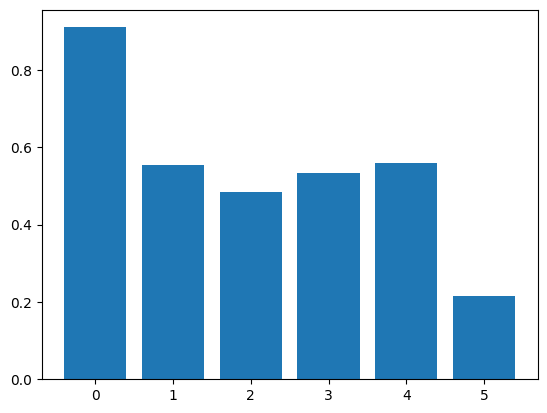

In [14]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [16]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

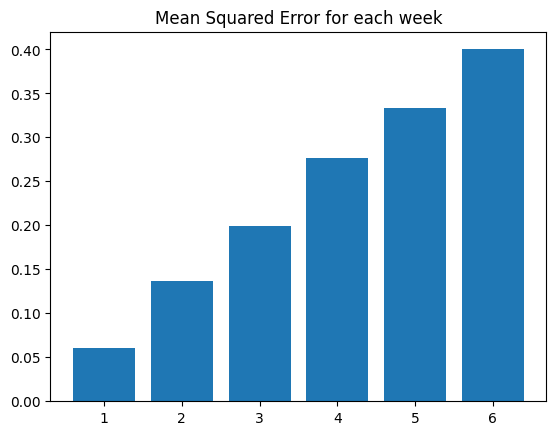

In [ ]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

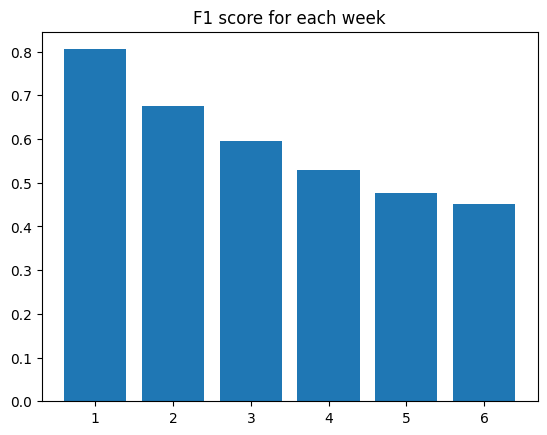

: 

In [20]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([8.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 9.000e+00, 1.900e+01,
        1.400e+01, 1.100e+01, 2.600e+01, 2.400e+01, 5.200e+01, 1.110e+02,
        1.390e+02, 1.760e+02, 2.470e+02, 5.230e+02, 1.282e+03, 3.388e+03,
        4.134e+03, 1.051e+03, 7.710e+02, 6.200e+02, 5.000e+02, 5.230e+02,
        4.590e+02, 2.440e+02, 1.540e+02, 1.080e+02, 5.800e+01, 6.500e+01,
        5.000e+01, 3.700e+01, 2.000e+01, 1.300e+01, 4.000e+00, 5.000e+00,
        7.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.64413309, -2.50065233, -2.35717157, -2.21369081, -2.07021005,
        -1.92672929, -1.78324852, -1.63976776, -1.496287  , -1.35280624,
        -1.20932548, -1.06584472, -0.92236396, -0.7788832 , -0.63540244,
        -0.49192168, -0.34844091, -0.20496015, -0.06147939,  0.08200137,
         0.22548213,  0.36896289,  0.51244365,  0.65592441,  0.79940517,
         0.94288593,  1.0863667 ,  1.22984746,  1.37332822,  1.51680898,
         1.66028974,  1.8037705 ,  1.94725126,  2.09073202,  2.2

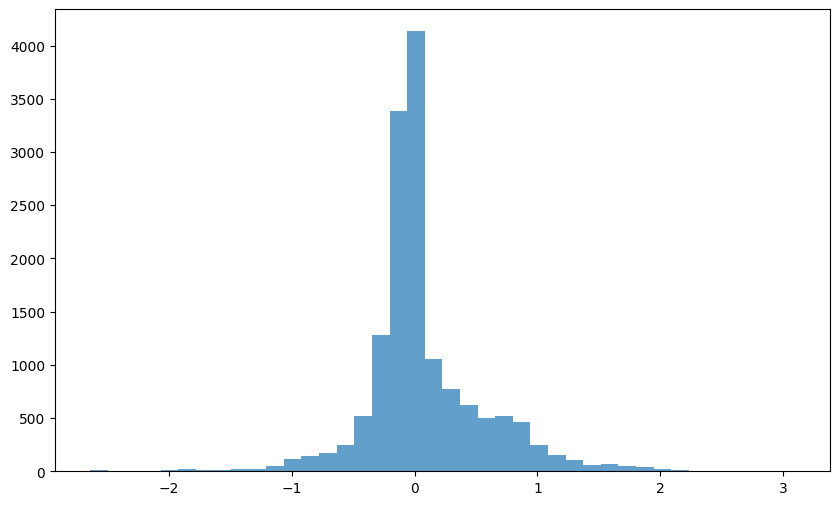

In [16]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

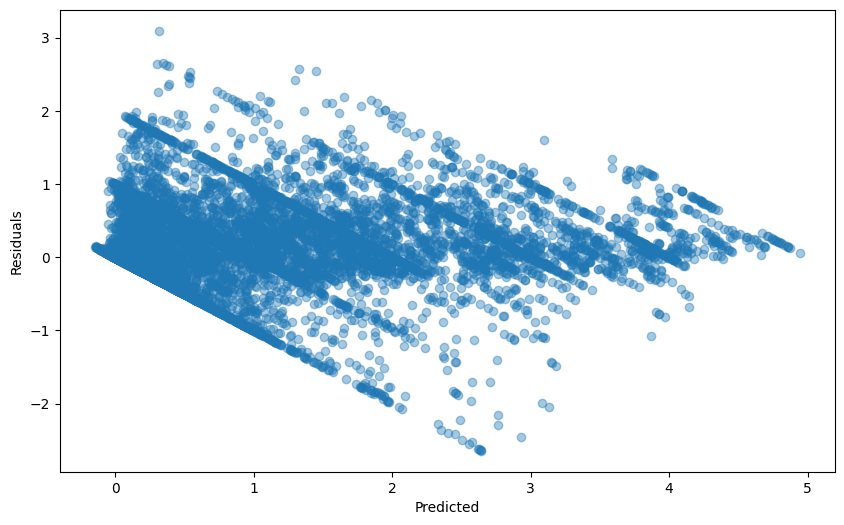

In [15]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

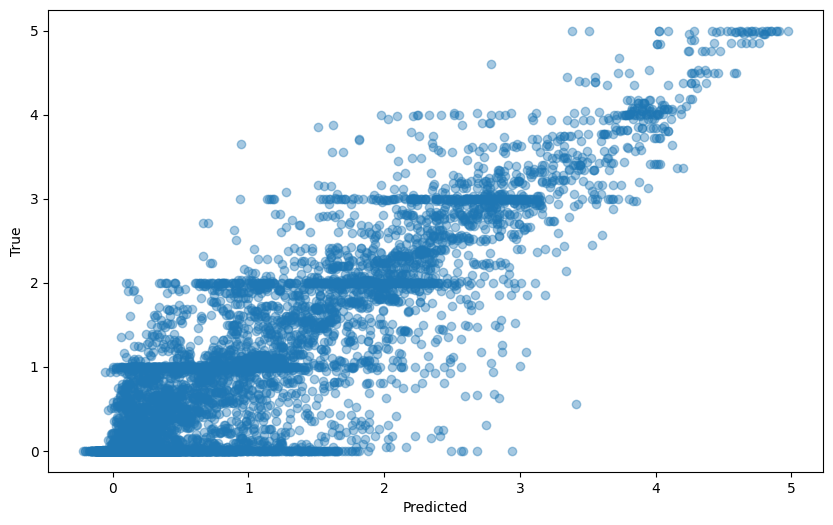

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")